In [4]:
import matplotlib.pyplot as plt
import env.guide_sim as gs
import params
import torch
import torchvision.transforms as transforms
import random
import os

## 加载导丝仿真环境

In [5]:
dataset_path = "datas/vivo_multi_branch/"
tasks = os.listdir(os.path.join(dataset_path, "task"))
tasks = [os.path.join(dataset_path, "task", t) for t in tasks]
env = gs.GuidewireEnv(tasks[0])

## 尝试加载导丝环境

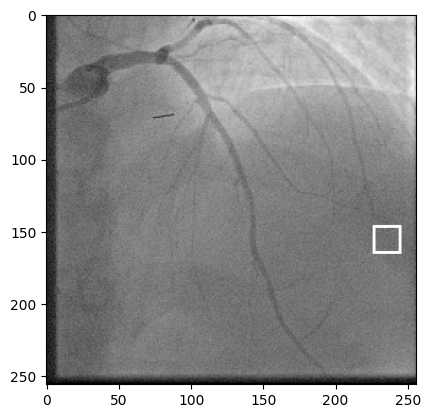

In [6]:
img = env.reset()  # 重置环境（每次要开始交互之前必须这么做）（输入代表根据序号开启某个任务）
plt.imshow(img[0], cmap='gray')

## 图片做域随机化处理


In [40]:
# 定义转换管道，包括域随机化
transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 随机改变颜色属性
    transforms.RandomResizedCrop(size= (256, 256), scale=(0.95, 1.0)),  # 随机裁剪并调整大小
    transforms.RandomRotation(degrees=2),  # 随机旋转
])


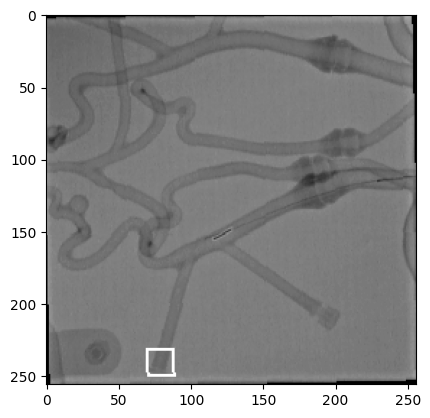

In [57]:
tensor = torch.from_numpy(img)
tensor = transform(tensor)
tensor.shape
plt.imshow(tensor[0], cmap='gray')

## 尝试交互 (往前推进十次)

0 0.0 False [318, 218]
1 0.0 False [324, 209]
2 0.0 False [329, 213]
3 0.0 False [324, 223]
4 0.0 False [328, 213]
5 0.0 False [328, 213]
6 0.0 False [323, 223]
7 0.0 False [318, 233]
8 0.0 False [325, 249]
9 0.0 False [326, 240]
10 0.0 False [326, 240]
11 0.0 False [321, 234]
12 0.0 False [321, 230]
13 0.0 False [321, 230]
14 0.0 False [321, 235]
15 0.0 False [321, 231]
16 0.0 False [319, 228]
17 0.0 False [318, 226]
18 0.0 False [318, 225]
19 0.0 False [323, 215]
20 0.0 False [329, 212]
21 0.0 False [335, 207]
22 0.0 False [337, 205]
23 0.0 False [337, 204]
24 0.0 False [348, 198]
25 0.0 False [347, 199]
26 0.0 False [348, 198]
27 0.0 False [369, 191]
28 0.0 False [365, 194]
29 0.0 False [372, 187]
30 0.0 False [369, 175]
31 0.0 False [369, 175]
32 0.0 False [358, 180]
33 0.0 False [359, 180]
34 0.0 False [365, 193]
35 0.0 False [371, 185]
36 0.0 False [369, 175]
37 0.0 False [368, 180]
38 0.0 False [365, 194]
39 0.0 False [372, 186]
40 0.0 False [377, 175]
41 0.0 False [370, 191]
42

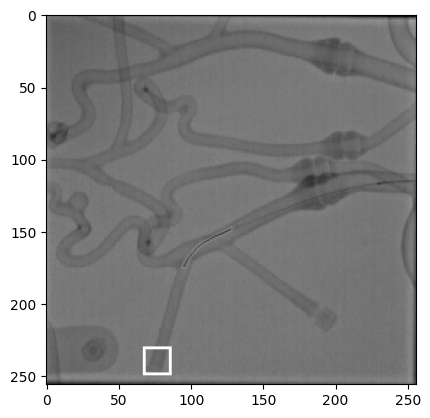

In [67]:
env.reset()
for i in range(500):
    img, reward, is_done, _ = env.step(random.choice([0, 1, 2, 3]))  # 执行一个动作（0: 推进， 1： 撤回， 2，3：旋转）
    print(i, reward, is_done, _[0])
    if is_done:
        break
plt.imshow(img[0], cmap='gray') 

([350, 191], [155, 480])

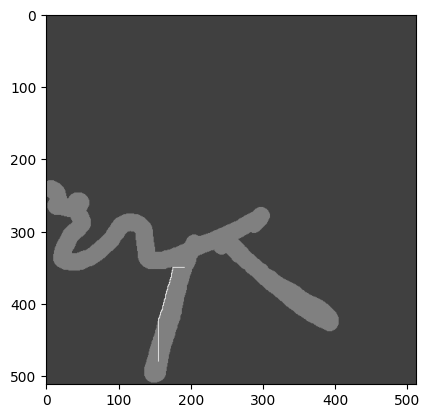

In [68]:
plt.imshow(env._mask_surf_np, cmap='gray', alpha=0.5)
plt.imshow(env.a_star_path_np, cmap='gray', alpha=0.5)

env.get_now_tip_pos(), env.metadata.target_pos

In [7]:
def l2_distance(point1, point2):
    """
    没有开根的欧氏距离 (为了优化计算速度)
    """
    return ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) ** 0.5

In [9]:
import numpy as np
import math

( np.sum(env.a_star_path_np), 
 l2_distance(env.get_now_tip_pos(), env.metadata.target_pos),
 -math.log( np.sum(env.a_star_path_np) * 0.001 ))

(241, 297.43570733857763, 1.422958345491482)

In [6]:
env._mask_surf_np.shape

(512, 512, 3)

我们的目标是训练一个AI，能够根据图像输入学习到将导丝推送到目标位置（白框）

## 需要尽可能的提升增加泛化性

这个仿真器提供了多种不同的任务，包括不同形状和大小的目标，不同难度的背景，不同难度的导丝路径

## 尝试使用Qwen2.5VL


In [70]:
from agents.qwen_vl import Agent

In [71]:
openai_api_key = "EMPTY"
openai_api_base = "http://192.168.1.110:1234/v1"
model="qwen2.5-vl-7b-instruct"
agent = Agent(openai_api_key, openai_api_base, model)

In [72]:
chat_response = agent.chat_with_array(img[0],
                    "将导丝递送到白框位置，你可以推进，后退，左转和右转，请输出你认为的导丝动作选择")  # 与agent对话
plt.imshow(img[0], cmap='gray')

APIConnectionError: Connection error.

In [18]:
chat_response.choices[0].message.content  # 获取回复内容

'根据图像显示的信息，导丝已经到达了白框的位置。因此，在这种情况下，不需要进行任何操作来移动或调整导丝。导丝已经在目标位置，可以保持不动。\n\n所以，正确的答案是：无需进行任何操作（即“静止”）。'